# Fraud & Cyber-Threat Prediction — End-to-End Notebook
Goal:Predict fraudulent / cyber-risky transactions using transaction metadata, behavioral features, and market stress indicators.

Author: Milani Chikeka  

Seed:42
---
Sections
1. Setup & imports  
2. Load dataset (Kaggle `creditcard.csv` recommended) or simulate synthetic transactions  
3. Market stress synthetic enrichment (USD/ZAR returns, VIX proxy, repo rate changes)  
4. Feature engineering (behavioral + transaction + stress features)  
5. Train/test split & imbalance handling  
6. Models: Logistic Regression baseline + LightGBM (main)  
7. Evaluation: ROC, PR, confusion matrix, business metrics  
8. Explainability: SHAP plots  
9. Save model & preprocessing pipeline


In [1]:
#Setups and imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings  
#import lightgbm as lgb
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, precision_recall_curve,average_precision_score ,confusion_matrix,classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional libraies and seedings
""" try:
    import lightgbm as lgb
except Exception as e:
    print("install lightgbm: pip install lightgbm")
    raise e  """

try:
    import shap 
except Exception as e:
    print("install shap: pip install shap")
    raise e

#This is for imbalanbce handling.
try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    print("Install imbalanced-learn: pip install imbalanced-learn")    
    raise e

RandomSeed=42
np.random.mtrand.RandomState(RandomSeed)

#Style plotting
sns.set(style="whitegrid")
    

#2Load the date/create synthetic data.
-Load the Kaggle dataset `creditcard.csv`, put it in `./data/creditcard.csv`.
-If dataset is not present, create 'synthetic' transaction datasets.

In [2]:
#In this cell, the dataset is loaded and basic EDA is performed.
DataDir="data"
os.makedirs(DataDir,exist_ok=True)
Dataset=os.path.join(DataDir, "./my_dataset.csv") #Relative path to dataset

if os.path.exists(Dataset):
    print("Loading dataset from local directory.")
    df=pd.read_csv(Dataset)
    #Kaggle datasets has "TIME", "Amount" , and "Class" columns.
    #Create synthetic categorical features for demonstration.
    df=df.reset_index(drop=True)
    #A synthetic timeframe will be created
    StartDate=datetime(2020,1,1)
    df['timestamp']=df['Time'].apply(lambda x: StartDate + timedelta(seconds=int(x)))
    #Categorical features are created
    df['DeviceType']=np.random.choice(['Mobile','Desktop','Tablet'], size=10,p=[0.5,0.1,0.4])
    df['Browser']=np.random.choice(['Chrome', 'Firefox', 'Safari', 'Edge'], size=10, p=[0.4,0.1,0.4,0.1])
    df['MerchantCategory']=np.random.choice(['Retail', 'Food', 'Travel', 'Entertainment','Health'], size=10, p=[0.3,0.2,0.2,0.2,0.1])
    df['Country']=np.random.choice(['ZA','UK', 'US', 'CHN', 'IND'], size=10, p=[0.3,0.2,0.2,0.2,0.1])
    df=df.rename(columns={'Amount':'amount','Class':'is_fraud'})
    
else:
    print("Dataset not found. Will create a synthetic dataset.")
    n=20000
    #Simulate the users base
    users=np.random.randint(1,20000, size=n)
    StartDate=datetime(2020,1,1)
    timestamps=[StartDate + timedelta(seconds=int(x)) 
                for x in np.random.exponential(scale=3600, size=n).cumsum()]
    amounts=np.random.exponential(scale=100, size=n)
#Labeling transactions as fraud or not based on amount and random noise
IsFraud=(np.random.rand(n) < 0.002).astype(int) #Around 0.2% frauds
DeviceType=np.random.choice(['Mobile','Desktop', 'Tablet'], size=n, p=[0.5,0.1,0.4])
Browser=np.random.choice(['Chrome', 'Firefox', 'Safari', 'Edge'], size=n, p=[0.4,0.1,0.4,0.1])
MerchantCategory=np.random.choice(['Retail', 'Food', 'Travel', 'Entertainment','Health'], size=n, p=[0.3,0.2,0.2,0.2,0.1])
Country=np.random.choice(['ZA','UK', 'US', 'CHN', 'IND'], size=n, p=[0.3,0.2,0.2,0.2,0.1])

df=pd.DataFrame({
    'users': users,
    'timestamp': timestamps,
    'amount': amounts,
    'is_fraud': IsFraud,
    'DeviceType': DeviceType,
    'Browser': Browser,
    'MerchantCategory': MerchantCategory,
    'Country': Country,
})


df.head()

Dataset not found. Will create a synthetic dataset.


,users,timestamp,amount,is_fraud,DeviceType,Browser,MerchantCategory,Country
0,4709,2020-01-01 00:58:54,29.116379,0,Desktop,Safari,Entertainment,ZA
1,15617,2020-01-01 03:39:53,159.980988,0,Tablet,Safari,Health,ZA
2,5696,2020-01-01 04:07:11,58.172305,0,Tablet,Chrome,Retail,CHN
3,2183,2020-01-01 04:53:54,48.700885,0,Mobile,Chrome,Retail,US
4,7633,2020-01-01 06:24:25,176.650399,0,Mobile,Chrome,Travel,UK


 #3 Synthetic Market Stress Enrichment
We will create a daily market stress series with:
- USD/ZAR returns
- VIX proxy (global vol)
- SARB repo rate change flags

Then merge the daily metrics onto each transaction by date.

In [3]:
#Create market stress data
#create a date range that covres the transaction timestamps
min_date=df['timestamp'].min().date()
max_date=df['timestamp'].max().date()
dates=pd.date_range(start=min_date, end=max_date)

# Simulate USD/ZAR daily returns (random walk with occasional shocks)
np.random.seed(42)
UsdZarLog=np.random.normal(loc=0, scale=0.01, size=len(dates))
#Add random shocks
Shock=np.random.choice(len(dates), size=int(len(dates)*0.05*len(dates)), replace=True)
UsdZarLog[Shock] += np.random.normal(loc=0.05, scale=0.02, size=len(Shock))

UsdZarLog=16.76*np.exp(np.cumsum(UsdZarLog)) #Starting rate around 16.76

#VIX index simulation
VixIndex=np.abs(np.random.normal(loc=12, size=len(dates)))
VixIndex[Shock] += np.random.normal(10, 5, size=len(Shock))
VixIndex=np.clip(VixIndex,10,None)

#repo rate simulation
RepoRate=np.full(len(dates),0.0675 ) #starts at 6.75%
ChangeIndixes=np.random.choice(len(dates), size=int(0.002*len(dates)), replace=False)
for idx in ChangeIndixes:
    RepoRate[idx:] += np.random.choice([0.25, -0.25, 0.5, -0.5]) #Changes in basis points

MarketData=pd.DataFrame({
    'date': dates,
    'UsdZar': UsdZarLog,
    'VixIndex': VixIndex,
    'RepoRate': RepoRate
})

#Compute the returns and volatility
MarketData['UsdzarReturn']=MarketData['UsdZar'].pct_change().fillna(0)
MarketData['UsdZarReturn7DayVol']=MarketData['UsdzarReturn'].rolling(7, min_periods=1).std().fillna(0)
MarketData['UsdZar7DayMean']=MarketData['VixIndex'].rolling(7, min_periods=1).mean().fillna(MarketData['VixIndex'])
#Mark the stress when UsdZar is less than -2% or VIX index is above 20 or Repo rate above 8%
MarketData['MarketStress']=((MarketData['UsdzarReturn'].abs() > 0.02) | (MarketData['VixIndex'] > MarketData['VixIndex'].quantile(0.90))).astype(int)
MarketData.rename(columns={'UsdzarReturn': 'UsdZarReturn'}, inplace=True)

MarketData.head()

,date,UsdZar,VixIndex,RepoRate,UsdZarReturn,UsdZarReturn7DayVol,UsdZar7DayMean,MarketStress
0,2020-01-01,16.867826,26.649556,0.0675,0.000000,0.000000,26.649556,0
1,2020-01-02,18.099243,20.706721,0.0675,0.073004,0.051622,23.678138,1
2,2020-01-03,19.942295,19.394113,0.0675,0.101830,0.052488,22.250130,1
3,2020-01-04,21.940214,23.570197,0.0675,0.100185,0.047704,22.580147,1
4,2020-01-05,22.473068,23.617679,0.0675,0.024287,0.045850,22.787653,1


Merge market features into transactions (by date).


In [4]:
#Merge market data with transaction data by date
df['date']=pd.to_datetime(df['timestamp'].dt.date)
df=df.merge(MarketData, on='date', how='left')

#Fill empty market data for missing dates
df[['UsdZar', 'VixIndex', 'RepoRate', 'UsdZarReturn', 'UsdZarReturn7DayVol', 'UsdZar7DayMean', 'MarketStress']] = \
    df[['UsdZar', 'VixIndex', 'RepoRate', 'UsdZarReturn', 'UsdZarReturn7DayVol', 'UsdZar7DayMean', 'MarketStress']].fillna(method='ffill').fillna(0)
df.head()

,users,timestamp,amount,is_fraud,DeviceType,Browser,MerchantCategory,Country,date,UsdZar,VixIndex,RepoRate,UsdZarReturn,UsdZarReturn7DayVol,UsdZar7DayMean,MarketStress
0,4709,2020-01-01 00:58:54,29.116379,0,Desktop,Safari,Entertainment,ZA,2020-01-01,16.867826,26.649556,0.0675,0.0,0.0,26.649556,0
1,15617,2020-01-01 03:39:53,159.980988,0,Tablet,Safari,Health,ZA,2020-01-01,16.867826,26.649556,0.0675,0.0,0.0,26.649556,0
2,5696,2020-01-01 04:07:11,58.172305,0,Tablet,Chrome,Retail,CHN,2020-01-01,16.867826,26.649556,0.0675,0.0,0.0,26.649556,0
3,2183,2020-01-01 04:53:54,48.700885,0,Mobile,Chrome,Retail,US,2020-01-01,16.867826,26.649556,0.0675,0.0,0.0,26.649556,0
4,7633,2020-01-01 06:24:25,176.650399,0,Mobile,Chrome,Travel,UK,2020-01-01,16.867826,26.649556,0.0675,0.0,0.0,26.649556,0


#4 Feature engineering — transactional & behavioral
We create:
- time features (hour, weekday)
- log amount
- rolling features per user (1h / 24h counts, avg amounts)
- device-country mismatch flag
- anomaly score: amount compared to user's historical mean


In [5]:
#Feature Engineering
# Remove duplicate columns before proceeding
df = df.loc[:, ~df.columns.duplicated(keep='first')]

# Ensure timestamp is datetime dtype, then extract time features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday

# Create Amount column to match downstream expected naming and keep log
if 'Amount' not in df.columns:
    df['Amount'] = df['amount']
df['AmountLog'] = np.log1p(df['Amount'])

#Sort by user and timestamp and ensure UserId exists
if 'UserId' not in df.columns:
    df['UserId'] = np.random.randint(1, 20000, size=len(df))
df = df.sort_values(by=['UserId', 'timestamp']).reset_index(drop=True)

# Rolling features (user-level)
# Compute rolling counts in the past 1 hour and 24 hours per user using two-pointer approach
def BuildUsersRollingFeatures(df, seconds_window, col_name):
    Out = []
    # iterate groups in the same order as df (df already sorted by UserId and timestamp)
    for uid, group in df.groupby('UserId', sort=False):
        # seconds since epoch as numpy array for fast indexing
        Times = (group['timestamp'].astype('int64') // 1_000_000_000).to_numpy()
        counts = []
        left = 0
        for i, t in enumerate(Times):
            while left < i and (t - Times[left]) > seconds_window:
                left += 1
            counts.append(i - left)
        Out.extend(counts)
    # assign (length should match df)
    df[col_name] = Out

# create 1h and 24h user tx count columns
BuildUsersRollingFeatures(df, seconds_window=3600, col_name='UserTxCount1h')
BuildUsersRollingFeatures(df, seconds_window=86400, col_name='UserTxCount24h')

# user historical stats (means and std) using the Amount column
UserStats = df.groupby('UserId')['Amount'].agg(['mean','std']).rename(columns={'mean':'UserAmountMean','std':'UserAmountStd'})
# merge using left_on UserId and right_index since UserStats uses UserId as index
df = df.merge(UserStats, left_on='UserId', right_index=True, how='left')

# If merge created suffixed columns due to prior columns, ensure canonical names exist
# prefer explicit names if present, otherwise take suffixed variants
if 'UserAmountMean' not in df.columns:
    for c in ['UserAmountMean_x', 'UserAmountMean_y']:
        if c in df.columns:
            df['UserAmountMean'] = df[c]
            break
if 'UserAmountStd' not in df.columns:
    for c in ['UserAmountStd_x', 'UserAmountStd_y']:
        if c in df.columns:
            df['UserAmountStd'] = df[c]
            break

# Amount anomaly score (z-score) - guard divide-by-zero and missing std
df['UserAmountStd'] = df['UserAmountStd'].replace(0, np.nan)
df['AmtZScore'] = (df['Amount'] - df['UserAmountMean']) / df['UserAmountStd']
df['AmtZScore'] = df['AmtZScore'].fillna(0)

# device-country mismatch flag: assume user primary country is mode country (safe mode extraction)
UserCountry = df.groupby('UserId')['Country'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).rename('UserPrimaryCountry')
df = df.merge(UserCountry, on='UserId', how='left')
# use the correct merged column name 'UserPrimaryCountry'
df['DeviceCountryMismatch'] = (df['Country'] != df['UserPrimaryCountry']).astype(int)

# Flagging for night transactions (between 12 AM to 6 AM) -- correct boolean logic
df['IsNightTransaction'] = df['hour'].apply(lambda x: 1 if (x > 0 and x < 6) else 0)

# Short-term rolling features - ensure feature list matches created columns
FeatCots = ['Amount', 'AmountLog', 'hour', 'weekday', 'UserTxCount1h', 'UserTxCount24h',
            'UserAmountMean','AmtZScore','DeviceType','MerchantCategory','Country',
            'UsdZarReturn','UsdZarReturn7DayVol','VixIndex','UsdZar7DayMean','RepoRate','MarketStress','IsNightTransaction','DeviceCountryMismatch']

len(df), df[FeatCots].head()

(20000,
        Amount  AmountLog  hour  weekday  UserTxCount1h  UserTxCount24h  \
 0  299.725697   5.706199    14        6              0               0   
 1  106.787622   4.680163    19        5              0               0   
 2   17.078902   2.894746    16        4              0               0   
 3  163.197287   5.101069     9        2              0               0   
 4   67.200839   4.222457    15        5              0               0   
 
    UserAmountMean  AmtZScore DeviceType MerchantCategory Country  \
 0      299.725697   0.000000     Mobile           Travel      US   
 1      106.787622   0.000000     Mobile             Food      UK   
 2       90.138094  -0.707107     Mobile             Food      UK   
 3       90.138094   0.707107     Mobile           Health      ZA   
 4       83.740447  -0.707107     Tablet           Health     IND   
 
    UsdZarReturn  UsdZarReturn7DayVol   VixIndex  UsdZar7DayMean  RepoRate  \
 0      0.030253             0.015091  27.3422

 #5 Prepare training dataset
- Choose modeling features.
- Encode categoricals using a ColumnTransformer pipeline.
- Train/test split stratified by label.


In [6]:

# Cell: 6 - prepare dataset for modeling
LabelCol = 'is_fraud'
# Some datasets have different naming conventions for the label column.
if LabelCol not in df.columns:
    LabelCol = 'Class' if 'Class' in df.columns else 'is_fraud'
Y = df[LabelCol].astype(int)
# Select features and target
NumFeatures = ['Amount', 'AmountLog', 'hour', 'weekday', 'UserTxCount1h', 'UserTxCount24h',
               'UserAmountMean', 'AmtZScore', 'UsdZarReturn', 'UsdZarReturn7DayVol', 'VixIndex',
               'UsdZar7DayMean', 'RepoRate', 'MarketStress', 'IsNightTransaction', 'DeviceCountryMismatch']
CatFeatures = ['DeviceType', 'MerchantCategory', 'Country']
X = df[NumFeatures + CatFeatures].copy()

# Handle infinities and NaNs
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=RandomSeed)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Fraud rate in train:", Y_train.mean(), "in test:", Y_test.mean())

Train shape: (16000, 19) Test shape: (4000, 19)
Fraud rate in train: 0.002 in test: 0.002


Preprocessing pipeline
- Standard scale numerical features
- One-hot encode small-cardinality categoricals

In [7]:
# Cell: 7 - preprocessing pipeline
# Remove duplicate columns from X_train and X_test before preprocessing
X_train = X_train.loc[:, ~X_train.columns.duplicated(keep='first')]
X_test = X_test.loc[:, ~X_test.columns.duplicated(keep='first')]

NumericTransormer=Pipeline(steps=[
    ('scaler', StandardScaler())])

CategoricalTransformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

Preprocessor=ColumnTransformer(transformers=[('Num', NumericTransormer, NumFeatures),
                                            ('Cat', CategoricalTransformer, CatFeatures)])

# Fit-transform training set to create feature matrix for simple models
XtrainP=Preprocessor.fit_transform(X_train)
XtestP=Preprocessor.transform(X_test)

print("Transformed feauture shape:", XtrainP.shape)

Transformed feauture shape: (16000, 29)


6) Handle class imbalance & Model training
We will:
- Train a LogisticRegression baseline with class weights.
- Train a LightGBM model (primary).
- Optionally use SMOTE for oversampling (toggle below).

In [8]:
# Cell: 8 - optional SMOTE toggle (use with caution)
from imblearn.over_sampling import SMOTE

UseSmote=False

# Ensure RandomSeed is available when cells are run out of order
RandomSeed = globals().get(RandomSeed, 42)

if UseSmote:
    print("Applying SMOTE to balance the classes in the training set.")
    Sm = SMOTE(random_state=RandomSeed, n_jobs=-1)
    XtrainPRes, YtrainPRes = Sm.fit_resample(XtrainP, Y_train)
else:
    XtrainPRes, YtrainPRes = XtrainP, Y_train

print("Post-resample shape:", XtrainPRes.shape, "Fraud rate:", YtrainPRes.mean())

Post-resample shape: (16000, 29) Fraud rate: 0.002


In [9]:
# Cell: 9 - Logistic Regression baseline
Lr=LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RandomSeed)
Lr.fit(XtrainPRes, YtrainPRes)
ProbLr=Lr.predict_proba(XtestP)[:,1]
print("Logistic Regression AUC-ROC:", roc_auc_score(Y_test, ProbLr))
print(classification_report(Y_test, Lr.predict(XtestP)))

Logistic Regression AUC-ROC: 0.5350075150300602
              precision    recall  f1-score   support

           0       1.00      0.66      0.79      3992
           1       0.00      0.38      0.00         8

    accuracy                           0.66      4000
   macro avg       0.50      0.52      0.40      4000
weighted avg       1.00      0.66      0.79      4000



In [13]:
# Cell: 10 - LightGBM model (with sklearn wrapper)
# We'll use plain lgb.Dataset approach via sklearn wrapper for convenience.
import lightgbm as lgb
lgbm=lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    objective='binary',
    class_weight='balanced',
    random_state=RandomSeed,
    n_jobs=-1
)
lgbm.fit(XtrainPRes, YtrainPRes,
         eval_set=[(XtestP, Y_test)],
         eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
            )

ProbLgbm=lgbm.predict_proba(XtestP)[:,1]
print("LightGBM AUC-ROC:", roc_auc_score(Y_test, ProbLgbm))
print(classification_report(Y_test, lgbm.predict(XtestP)))

[LightGBM] [Info] Number of positive: 32, number of negative: 15968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.478457	valid_0's binary_logloss: 0.481498
LightGBM AUC-ROC: 0.4784569138276553
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3992
           1       0.00      0.00      0.00         8

    accuracy                           0.91      4000
   macro avg       0.50      0.

7) Evaluation visuals & business-oriented metrics
- ROC, PR curves
- Confusion matrix at chosen threshold
- Precision@K / Lift if needed

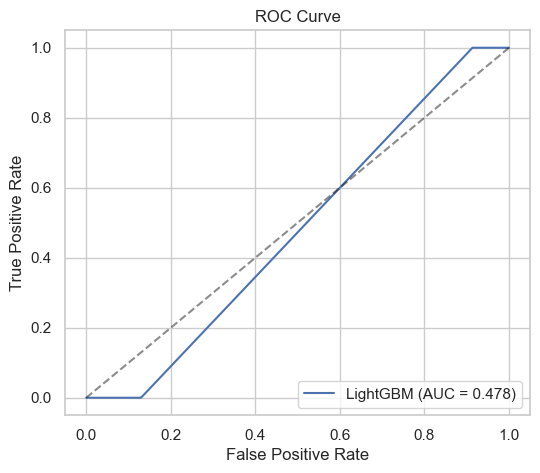

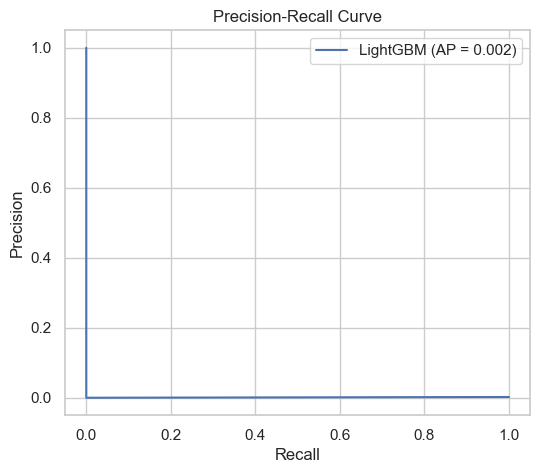

In [14]:
from sklearn.metrics import roc_curve, auc

#ROC
fpr, tpr, _=roc_curve(Y_test, ProbLgbm)
roc_auc=auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, ProbLgbm)
ap = average_precision_score(Y_test, ProbLgbm)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'LightGBM (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()



Threshold: 0.5
{'tn': np.int64(3623), 'fp': np.int64(369), 'fn': np.int64(8), 'tp': np.int64(0), 'cm': array([[3623,  369],
       [   8,    0]])}


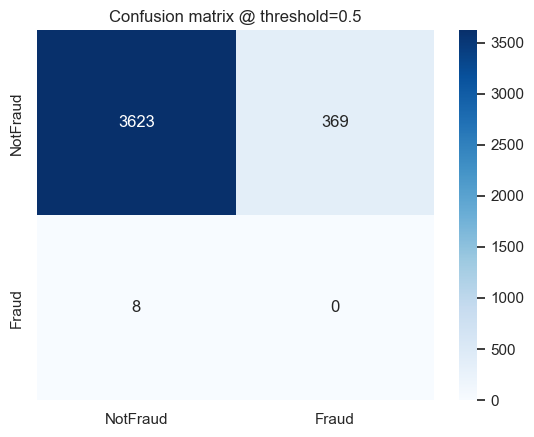

Precision: 0.0
Recall: 0.0
F1: 0.0


In [16]:
# Cell: 12 - Confusion matrix at a chosen threshold
def conf_matrix_at_threshold(y_true, probs, thresh=0.5):
    Preds = (probs >= thresh).astype(int)
    Cm = confusion_matrix(y_true, Preds)
    tn, fp, fn, tp = Cm.ravel()
    return {'tn':tn,'fp':fp,'fn':fn,'tp':tp,'cm':Cm}

th = 0.5
cm_stats = conf_matrix_at_threshold(Y_test, ProbLgbm, thresh=th)
print("Threshold:", th)
print(cm_stats)
sns.heatmap(cm_stats['cm'], annot=True, fmt='d', cmap='Blues', xticklabels=['NotFraud','Fraud'], yticklabels=['NotFraud','Fraud'])
plt.title(f'Confusion matrix @ threshold={th}')
plt.show()

# Show classification report for thresholded predictions
from sklearn.metrics import precision_score, recall_score, f1_score
preds_th = (ProbLgbm >= th).astype(int)
print("Precision:", precision_score(Y_test, preds_th))
print("Recall:", recall_score(Y_test, preds_th))
print("F1:", f1_score(Y_test, preds_th))

 Business metric: Expected Loss Avoided (toy example)
- Suppose average fraud amount is `avg_fraud_amt`.
- False negative = missed fraud (cost = amount)
- False positive = manual review cost = e.g., 5 USD
Compute net saved loss vs baseline.

In [17]:
# Cell: 13 - toy business metric
AvgFraudAmt=df.loc[df[LabelCol]==1, 'amount'].mean() if df[LabelCol].sum() >0 else 100
ManuelReviewCost=5.0

tn, fp, fn, tp = cm_stats['tn'], cm_stats['fp'], cm_stats['fn'], cm_stats['tp']
ExpectedLossMissed=fn*AvgFraudAmt
ExpectedManualReviewCost=(tp*fp) *ManuelReviewCost
print(f"Avg fraud amount: {AvgFraudAmt:.2f}")
print(f"Missed frauds (fn): {fn}, cost approx: {ExpectedLossMissed:.2f}")
print(f"Manual reviews (tp+fp): {(tp+fp)}, cost approx: {ExpectedManualReviewCost:.2f}")

Avg fraud amount: 116.76
Missed frauds (fn): 8, cost approx: 934.10
Manual reviews (tp+fp): 369, cost approx: 0.00


8) Explainability — SHAP
SHAP helps explain LightGBM predictions (global and single prediction).

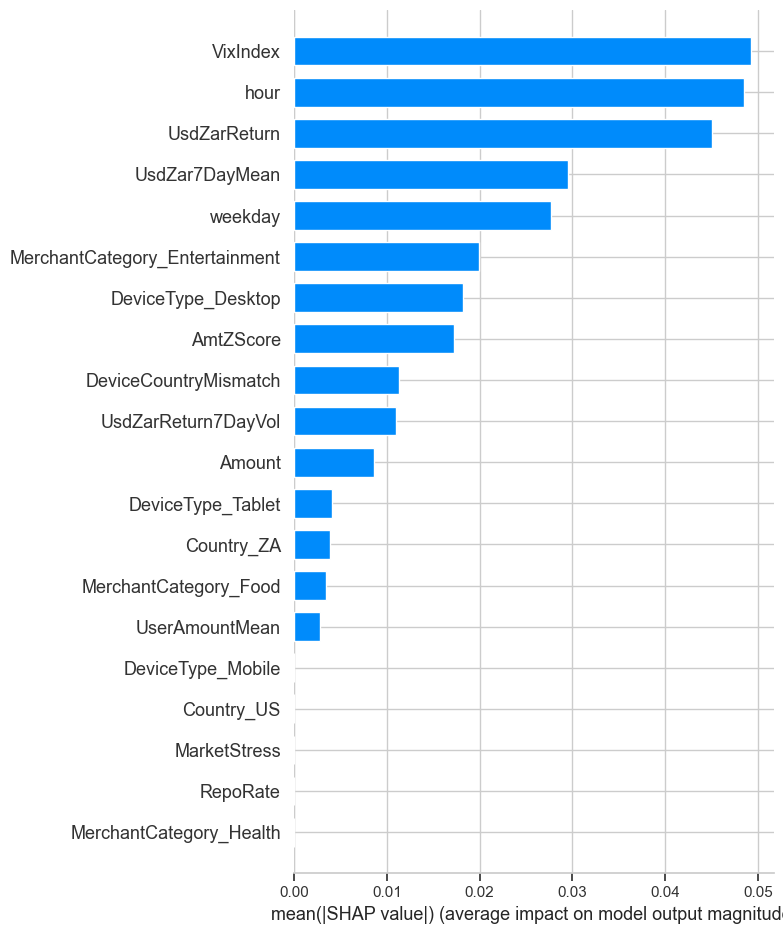

In [18]:
# Cell: 14 - SHAP explainability
# Create a small sample to speed shap runtime
import shap
SampleIndices=np.random.choice(X_test.shape[0], size=min(1000, X_test.shape[0]), replace=False)
XShapSample=X_test.iloc[SampleIndices]
XShapSampleP=Preprocessor.transform(XShapSample)

# Build feature names after preprocessing
# numeric names + ohe names
NumNames=NumFeatures
ohe=Preprocessor.named_transformers_['Cat'].named_steps['ohe']
oheNames=ohe.get_feature_names_out(CatFeatures).tolist()
FeatureNames=NumNames + oheNames

# Use TreeExplainer for LightGBM
Explainer=shap.TreeExplainer(lgbm)
ShapValues=Explainer.shap_values(XShapSampleP)

# Summary plot (global importance)
shap.summary_plot(ShapValues, XShapSampleP, feature_names=FeatureNames, plot_type='bar', show=True)

SHAP waterfall for a single example
Pick a high-risk transaction from the test set and show local explanation.

Predicted fraud probability for the highest risk transaction: 0.6396695623911235


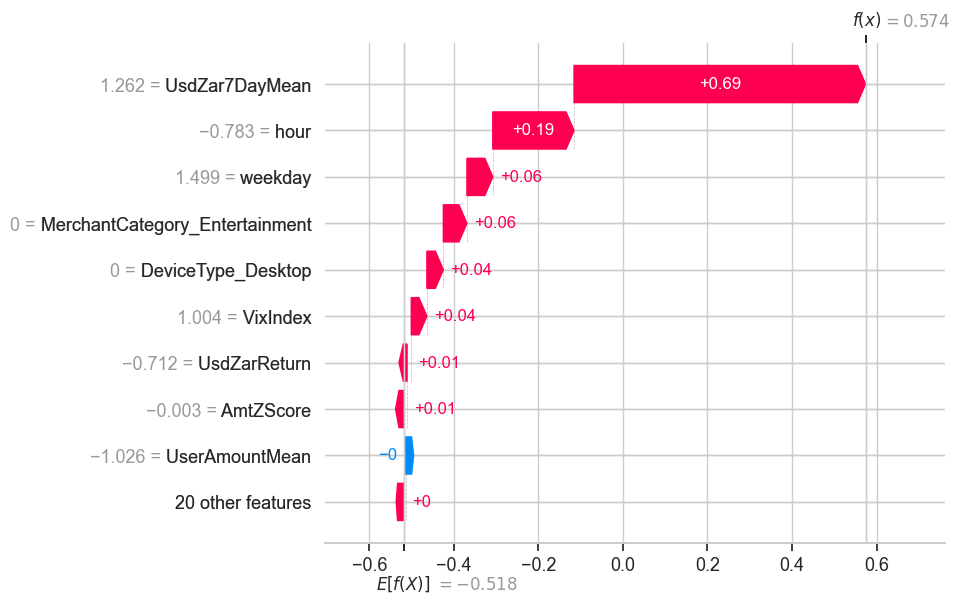

In [19]:
# Cell: 15 - SHAP waterfall for single transaction (fixed)
# pick the highest predicted risk transaction in the test set

HighRiskIdx = np.argmax(ProbLgbm)

# Use the original (preprocessed) pandas row from X_test, then transform
SingleRow_df = X_test.iloc[[HighRiskIdx]]
SingleRowP = Preprocessor.transform(SingleRow_df)  # shape (1, n_features)

# Compute SHAP values for the single transformed row
SingleShap = Explainer.shap_values(SingleRowP)

# Handle binary-class vs single-array shap output: pick positive-class contributions
if isinstance(SingleShap, list) and len(SingleShap) > 1:
    shap_vals = SingleShap[1][0]  # positive class, first (and only) sample
else:
    # SingleShap could be array of shape (1, n) or (n,) depending on shap version
    shap_vals = SingleShap[0] if getattr(SingleShap, 'ndim', 1) == 2 else SingleShap

# Determine base value for positive class if provided as array
ev = Explainer.expected_value
base_value = ev[1] if (isinstance(ev, (list, np.ndarray)) and len(ev) > 1) else ev

print("Predicted fraud probability for the highest risk transaction:", ProbLgbm[HighRiskIdx])

# Build Explanation and plot waterfall (data is the 1D feature vector)
shap.waterfall_plot(
    shap.Explanation(values=shap_vals,
                     base_values=base_value,
                     data=SingleRowP[0],
                     feature_names=FeatureNames),
    show=True
)

 9) Save model & preprocessing pipeline
Save both the trained LightGBM model and the preprocessing pipeline for later deployment (Streamlit or API).

In [20]:
#Cell: 16 -  Save the model and preprocessor
OutDIr="models"
os.makedirs(OutDIr, exist_ok=True)

joblib.dump(Preprocessor, os.path.join(OutDIr, "preprocessor.joblib"))
joblib.dump(lgbm, os.path.join(OutDIr, "lgbm_model.joblib"))
joblib.dump(Lr, os.path.join(OutDIr, "logistic_regression_model.joblib"))

print("Saved preprocessor and models to ./models/")

Saved preprocessor and models to ./models/
